BWA and minimap2 resulted in slightly different variant calling validation results, running on the ICGC MB dataset (100x tumor vs 100x normal). Trying to understand the origin of that discrepancy.

In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statistics import median, mean
from pprint import pprint
import sys

Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls. Earlier we evaluated calls against the truth set, so here we have 3 sets of VCFs for each caller: `0000.vcf` (false positives), `0001.vcf` (false negatives), `0002.vcf` (true positives).

In [24]:
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from os.path import join
from collections import Counter
import tabix

callers = ['strelka2', 'vardict', 'mutect2']

vcfs = {}
for c in callers:
    bwa_dir = f'mb_eval/batch1-{c}-annotated-bwa_bcftools_isec'
    mm2_dir = f'mb_eval/batch1-{c}-annotated_bcftools_isec'
    vcfs[c] = dict(
        bwa=dict(
            fp=join(bwa_dir, '0000.anno.vcf'),
            fn=join(bwa_dir, '0001.anno.vcf'),
            tp=join(bwa_dir, '0002.anno.vcf'),
        ),
        mm2=dict(
            fp=join(mm2_dir, '0000.anno.vcf'),
            fn=join(mm2_dir, '0001.anno.vcf'),
            tp=join(mm2_dir, '0002.anno.vcf'),
        ),
    )
validate_types = ['fp', 'tp', 'fn']

main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def extract_mq(rec_, caller_):
    if rec_ is None:
        return None
    if caller_ == 'vardict':
        try:
            return rec_.format('MQ')[main_sample_index][0]
        except:
            print(rec_)
            raise
    if caller_ == 'strelka2':
        try:
            return rec_.INFO['MQ']
        except:
            print(rec_)
            raise
    if caller_ == 'mutect2':
        try:
            return rec_.format('MMQ')[main_sample_index][0] if rec_ else None
        except:
            print(rec_)
    
def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]

df_by_c = dict()
for caller in callers:
    print('Parsing VCFs for {caller}')
    recs_by_loc = defaultdict(lambda: [(None, 'tn'), (None, 'tn')])
    
    for typ, vcf in vcfs[caller]['bwa'].items():
        for rec in VCF(vcf):            
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.ALT[0])
            recs_by_loc[k][0] = (rec, typ)
            
    for typ, vcf in vcfs[caller]['mm2'].items():
        for rec in VCF(vcf):
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.ALT[0])
            recs_by_loc[k][1] = (rec, typ)
    
    print(f'Analysing data for {caller}, building dataframe')
    rows = []

    total = 0
    for (chrom, pos, alt), [(bwa, bwa_t), (mm2, mm2_t)] in sorted(recs_by_loc.items(), key=lambda a: a[0]):    
        assert bwa_t
        assert mm2_t
        
        total += 1
        
        x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
        if x is None:
            continue
        x += pos
                
        gene = ''
        if bwa_t.endswith('n'):
            bwa_dp = 0
            bwa_af = 0
            bwa_qual = 0
            bwa_mq = 0
            bwa_nm = 0
        else:
            try:
                bwa_af = bwa.format('AF')[main_sample_index]
            except:
                bwa_af = bwa.INFO.get('AF')
            try:
                bwa_dp = bwa_dp = bwa.format('DP')[main_sample_index]
            except:
                bwa_dp = bwa.INFO.get('DP')                
            if not isinstance(bwa_af, (int, float)): bwa_af = bwa_af[0]
            if not isinstance(bwa_dp, (int, float)): bwa_dp = bwa_dp[0]
            bwa_qual = bwa.QUAL
            if 'ANN' in bwa.INFO:
                gene = bwa.INFO['ANN'].split('|')[3]
            bwa_mq = extract_mq(bwa, caller) or 0
            bwa_nm = bwa.format('NM')[main_sample_index][0] if caller == 'vardict' else None
            
        if mm2_t.endswith('n'):
            mm2_dp = 0
            mm2_af = 0
            mm2_qual = 0
            mm2_mq = 0
            mmq_nm = 0
        else:
            try:
                mm2_af = mm2.format('AF')[main_sample_index]
            except:
                mm2_af = mm2.INFO.get('AF')
            try:
                mm2_dp = mm2_dp = mm2.format('DP')[main_sample_index]
            except:
                mm2_dp = mm2.INFO.get('DP')                
            if not isinstance(mm2_af, (int, float)): mm2_af = mm2_af[0]
            if not isinstance(mm2_dp, (int, float)): mm2_dp = mm2_dp[0]
            mm2_qual = mm2.QUAL
            if 'ANN' in mm2.INFO:
                gene = mm2.INFO['ANN'].split('|')[3]
            mm2_mq = extract_mq(mm2, caller) or 0
            mm2_nm = mm2.format('NM')[main_sample_index][0] if caller == 'vardict' else None
               
        tricky_anno = (bwa or mm2).INFO.get('TRICKY', '').split(',')
        tricky_anno = tuple([a for a in tricky_anno if a and a not in 
             ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']])
        
        rows.append({
            'pos': pos,
            'label': f'{chrom}:{pos}-{alt}', 
            'called_with_bwa': bwa is not None,
            'called_with_mm2': mm2 is not None,
            'chrom': chrom,
            'x': x,
            'passed': not (bwa or mm2).FILTER,
            'gene': gene,
            'bwa_af': bwa_af,
            'mm2_af': mm2_af,
            'bwa_dp': bwa_dp,
            'mm2_dp': mm2_dp,
            'bwa_mq': bwa_mq, 
            'mm2_mq': mm2_mq,
            'bwa_qual': bwa_qual,
            'mm2_qual': mm2_qual,
            'mq_diff': bwa_mq - mm2_mq,
            'bwa_nm': bwa_nm,
            'mm2_nm': mm2_nm,
            'bwa_validate': bwa_t,
            'mm2_validate': mm2_t,
            'tricky_anno': tricky_anno,
        })
        
    df_by_c[caller] = pd.DataFrame(rows)

    print(f'Done parsing {caller}, total variants: ', str(total))

Parsing VCFs for {caller}
Analysing data for strelka2, building dataframe
Done parsing strelka2, total variants:  2725
Parsing VCFs for {caller}
Analysing data for vardict, building dataframe
Done parsing vardict, total variants:  27146
Parsing VCFs for {caller}
Analysing data for mutect2, building dataframe
Done parsing mutect2, total variants:  13251


Counting statistics on variants calls with BWA only vs. minimap2 only vs. shared, drawing Venn diagrams for each caller.

strelka2
('fn', 'fn') 3872
('fn', 'tp') 2222
('fp', 'fp') 3366
('fp', 'tn') 10824
('tn', 'fp') 10186
('tp', 'fn') 3344
('tp', 'tp') 25982
vardict
('fn', 'fn') 7656
('fn', 'tp') 1958
('fp', 'fp') 27346
('fp', 'tn') 297022
('tn', 'fp') 223388
('tp', 'fn') 2244
('tp', 'tp') 23562
mutect2
('fn', 'fn') 3388
('fn', 'tp') 2134
('fp', 'fp') 11176
('fp', 'tn') 208692
('tn', 'fp') 33704
('tp', 'fn') 2596
('tp', 'tp') 27302
Done all


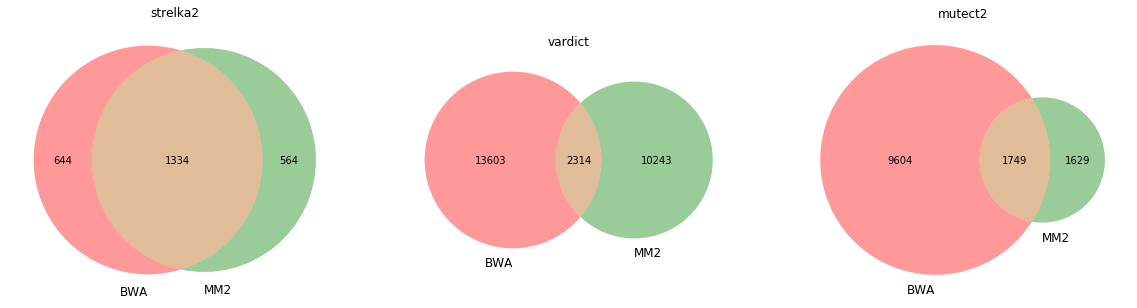

In [3]:
stats_by_chrom_by_caller = dict()

from matplotlib_venn import venn2, venn2_circles
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 10))
plt.title('BWA versus minimap2 calls for callers: ' + ', '.join(callers))
grid = gridspec.GridSpec(1, len(callers), width_ratios=[1] * len(callers))
for i, caller in enumerate(callers):
    # Printing FP/FN chromosome-wise stats
    print(caller)
    stats_by_chrom_by_caller[caller] = defaultdict(lambda: defaultdict(int))
    for category, g in df_by_c[caller].groupby(['bwa_validate', 'mm2_validate']):
        print(category, g.size)
        for _, r in g.iterrows():
            stats_by_chrom_by_caller[caller][r['chrom']][category] += 1
    
    # Plotting Venn
    ax = plt.subplot(grid[i])
    bwa_unique = sum(st[('tp', 'fn')] + st[('fp', 'tn')] for c, st in stats_by_chrom_by_caller[caller].items())
    mm2_unique = sum(st[('fn', 'tp')] + st[('tn', 'fp')] for c, st in stats_by_chrom_by_caller[caller].items())
    common     = sum(st[('tp', 'tp')] + st[('fp', 'fp')] for c, st in stats_by_chrom_by_caller[caller].items())
    subsets = {
        '10': bwa_unique,
        '01': mm2_unique,
        '11': common,
    }
    venn2(subsets, set_labels=('BWA', 'MM2'), ax=ax)
    ax.set_title(caller)
       
print(f'Done all')

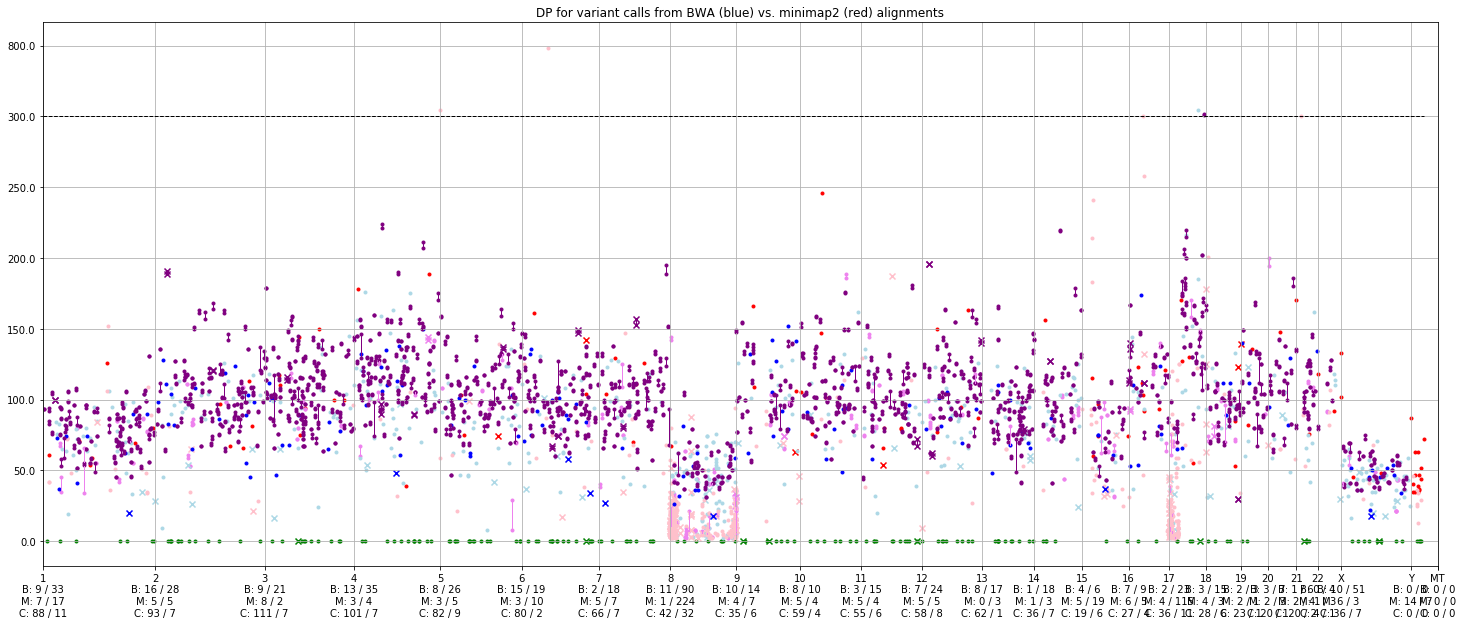

In [4]:
# Plotting functions

## Prepare colors for variant vs coordinate plots
from matplotlib.ticker import LinearLocator
def set_color(d):
    if d['validate'] == 'fn':
        color = 'green'
        zorder = 2
    
    if not d['called_with_bwa']:
        assert d['called_with_mm2']
        color = 'lightblue'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'blue'
            zorder = 1
            
    elif not d['called_with_mm2']:
        assert d['called_with_bwa']
        color = 'pink'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'red'
            zorder = 1
            
    else:
        assert d['called_with_bwa']
        assert d['called_with_mm2']
        color = 'gray'
        zorder = 1
        if d['validate'] == 'tp':
            color = 'black'
            zorder = -1
    return color, zorder

def get_colors(category):
    """ Return color of BWA dot, color of minimap2 dot, and color of line connecting dots
    """
    
    if category == ('tp', 'tp'):
        return 'purple', 'purple', 'purple'

    elif category == ('tp', 'fn'):
        return 'blue', None, None
    
    elif category == ('fp', 'fp'):
        return 'violet', 'violet', 'violet'

    elif category == ('fp', 'tn'):
        return 'lightblue', None, None
        
    elif category == ('fn', 'tp'):
        return None, 'red', None
        
    elif category == ('fn', 'fn'):
        return 'green', None, None
        
    elif category == ('tn', 'fp'):
        return None, 'pink', None
    
    else:
        return None, None, None

# for caller in callers:
#     df_by_c[caller]['color']  = df_by_c[caller].apply(lambda row: set_color(row)[0], axis=1)
#     df_by_c[caller]['zorder'] = df_by_c[caller].apply(lambda row: set_color(row)[1], axis=1)
# print(f'Done colors')

## Plotting chromosome ticks
def draw_ticks(ax, chrom=None):
    chrom_poss = chrom_positions
    if chrom:
        chrom_poss = [(c, p) for c, p in chrom_positions if c in [str(chrom), int_to_chrom(chrom_to_int(chrom) + 1)]]

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    
    return chrom_poss

## Plotting data
def plot(caller, field, field_name=None, chrom=None, diff=False, max_y=None):
    # Plotting MQ differrence by coordinate
    field_name = field_name or field.upper()

    fig = plt.figure(figsize=(25, 10))
    df = df_by_c[caller]
    ax = fig.add_subplot(111, label=f'{caller}_{field}', 
                         title=f'{field_name} for variant calls from BWA (blue) vs. minimap2 (red) alignments')

    chrom_poss = draw_ticks(ax, chrom)
    
    modify = modify_back = lambda v: v
    if max_y:
        modify = lambda v: max_y+(v-max_y)/10 if v > max_y else v
        modify_back = lambda v: max_y+(v-max_y)*10 if v > max_y else v
    
    # Plotting dots
    if diff:
        ax.scatter(df['x'], 
                   (df[f'bwa_{field}'] - df[f'mm2_{field}']).map(modify), 
                   marker='.', color=df['color'])
    else:
        for category, g in df.groupby(['bwa_validate', 'mm2_validate', 'tricky_anno']):
            (bwa_validate, mm2_validate, tricky_anno) = category
            bwa_color, mm2_color, line_color = get_colors((bwa_validate, mm2_validate))
            bys = g[f'bwa_{field}'].map(modify)
            mys = g[f'mm2_{field}'].map(modify)
            marker = 'x' if tricky_anno else '.'
            if bwa_color:
                ax.scatter(g['x'], bys, marker=marker, color=bwa_color)
            if mm2_color:
                ax.scatter(g['x'], mys, marker=marker, color=mm2_color)
            if line_color:
                for index, row in g.iterrows():
                    by = modify(row[f'bwa_{field}'])
                    my = modify(row[f'mm2_{field}'])
                    ax.plot([row['x'], row['x']], [by, my], color=line_color, linewidth=1)
        
        s = stats_by_chrom_by_caller[caller]
        plt.xticks([pos for c, pos in chrom_poss],
                   ['\n'.join([f'{c}', 
                               f'B: {s[c][("tp", "fn")]} / {s[c][("fp", "tn")]}', 
                               f'M: {s[c][("fn", "tp")]} / {s[c][("tn", "fp")]}', 
                               f'C: {s[c][("tp", "tp")]} / {s[c][("fp", "fp")]}']) if c else ''
                   for c, _ in chrom_poss])
        
        if max_y:
            ax.set_yticklabels([modify_back(l) for l in ax.get_yticks().tolist()])
            ax.plot([0, df['x'].max()], [max_y, max_y], color='black', linestyle='--', linewidth=1)
        
#         grouped = df.groupby('zorder')
#         for zorder, g in grouped:
#             ax.scatter(g['x'], g[f'bwa_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)
#             ax.scatter(g['x'], g[f'mm2_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    plt.grid()
    
    return df, ax

plot('strelka2', 'dp', max_y=300)
pass

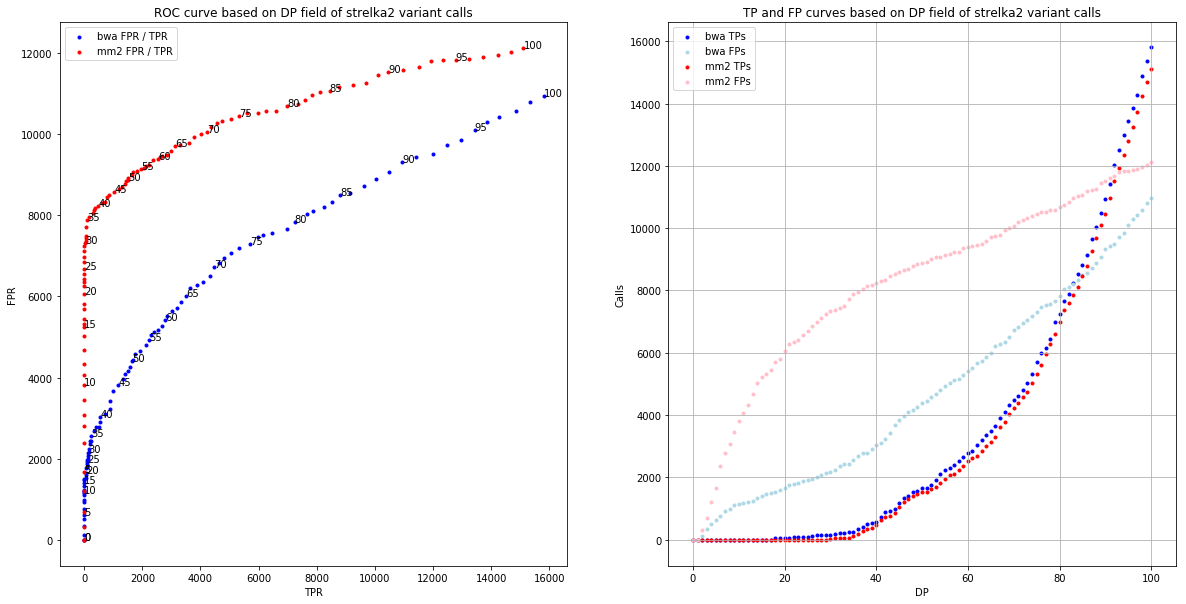

In [79]:
# Plot ROC curve
import scikitplot as skplt
from matplotlib import gridspec

def plot_roc(caller, field, start, end, step):
    fig = plt.figure(figsize=(20, 10))

    df = df_by_c[caller]

    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    roc_ax = plt.subplot(grid[0], 
         label=f'ROC {caller} {field.upper()}', 
         title=f'ROC curve based on {field.upper()} field of {caller} variant calls')
    tp_fp_ax = plt.subplot(grid[1], 
         label=f'TP and FP {caller} {field.upper()}', 
         title=f'TP and FP curves based on {field.upper()} field of {caller} variant calls')

    for i, aln, tp_color, fp_color in [
        (0, 'bwa', 'blue', 'lightblue'), 
        (1, 'mm2', 'red', 'pink'),
    ]:
        vals = range(start, end + 1, step)
        
        fps = []
        tps = []

        tprs = []
        fprs = []

        for val in vals:
            val_dfs = df[df[f'{aln}_{field}'] <= val]

            tp = val_dfs[val_dfs[f'{aln}_validate'] == 'tp'].size
            fn = val_dfs[val_dfs[f'{aln}_validate'] == 'fn'].size
            fp = val_dfs[val_dfs[f'{aln}_validate'] == 'fp'].size
            
            tps.append(tp)
            fps.append(fp)
            #tprs.append(tp / (tp + fn))
            #fprs.append(fp / (fp + tn))
        
        # ROC curve plots
        roc_ax.scatter(tps, fps, marker='.', color=tp_color, label=f'{aln} FPR / TPR')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')
#         ax.set_xlim(0, 1)
#         ax.set_ylim(0, 1)
        for x, y, l in zip(tps, fps, vals):
            if l % 5 == 0:
                roc_ax.annotate(l, xy=(x, y))
        
        # TP and FP plots
        tp_fp_ax.scatter(vals, tps, marker='.', color=tp_color, label=f'{aln} TPs')
        tp_fp_ax.scatter(vals, fps, marker='.', color=fp_color, label=f'{aln} FPs')
#        tp_fp_ax.legend(handles=[fps_scatter, tps_scatter])
        tp_fp_ax.set_xlabel(f'{field.upper()}')
        tp_fp_ax.set_ylabel('Calls')

    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels())
    roc_ax.legend(*roc_ax.get_legend_handles_labels())
    plt.grid()
        
# Strelka2 DP ROC curve
plot_roc('strelka2', 'dp', 0, 100, 1)
pass

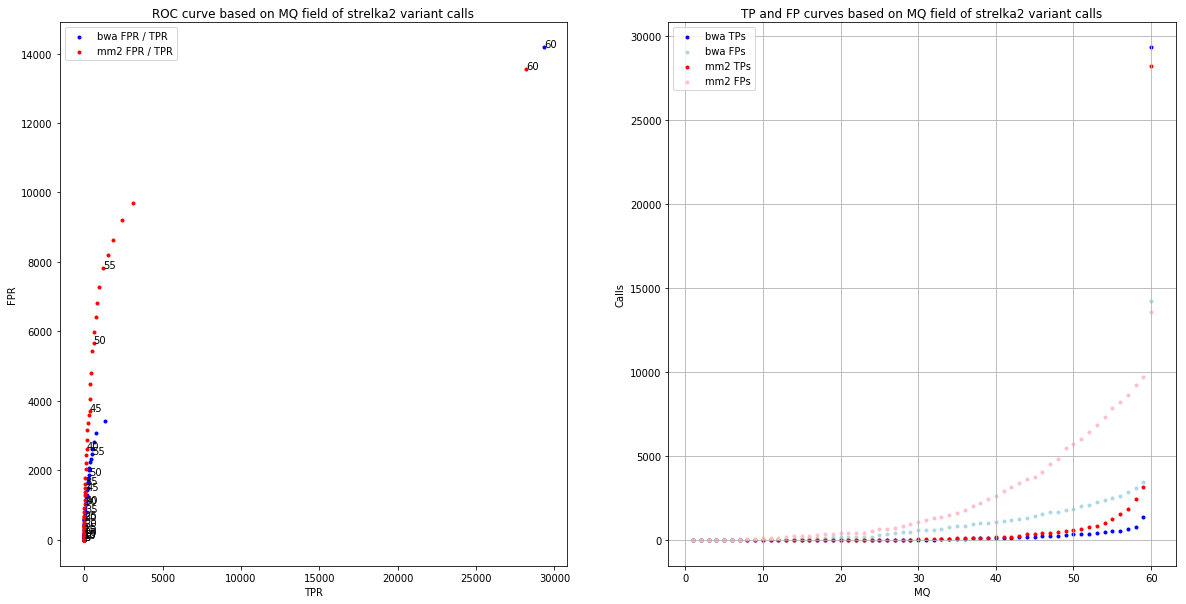

In [81]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'mq', 1, 60, 1)
pass

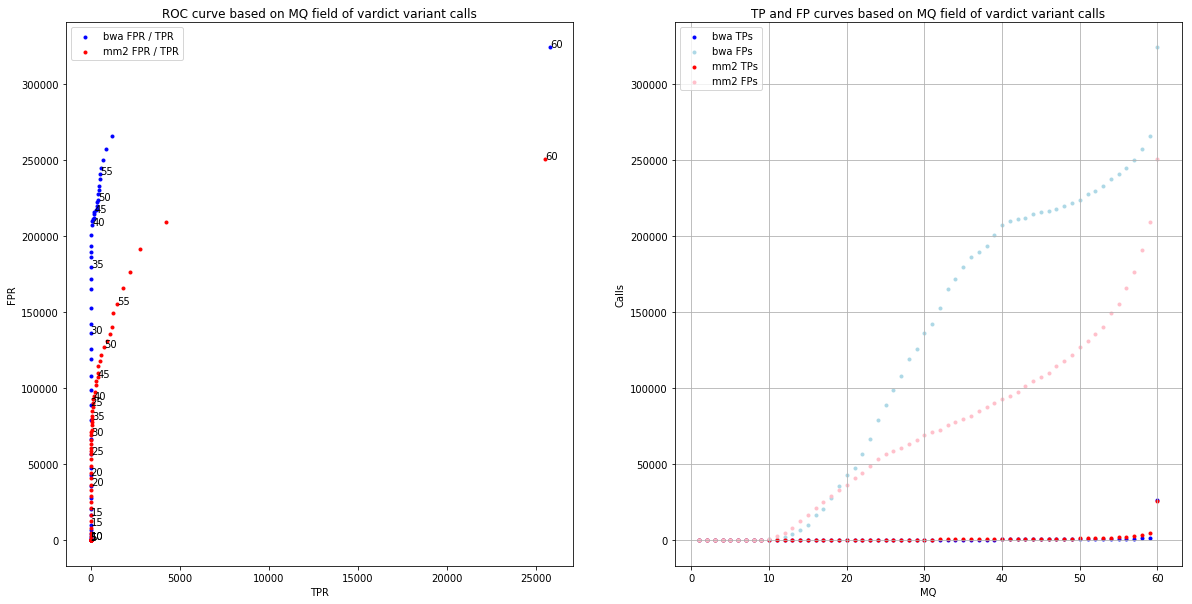

In [82]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'mq', 1, 60, 1)
pass

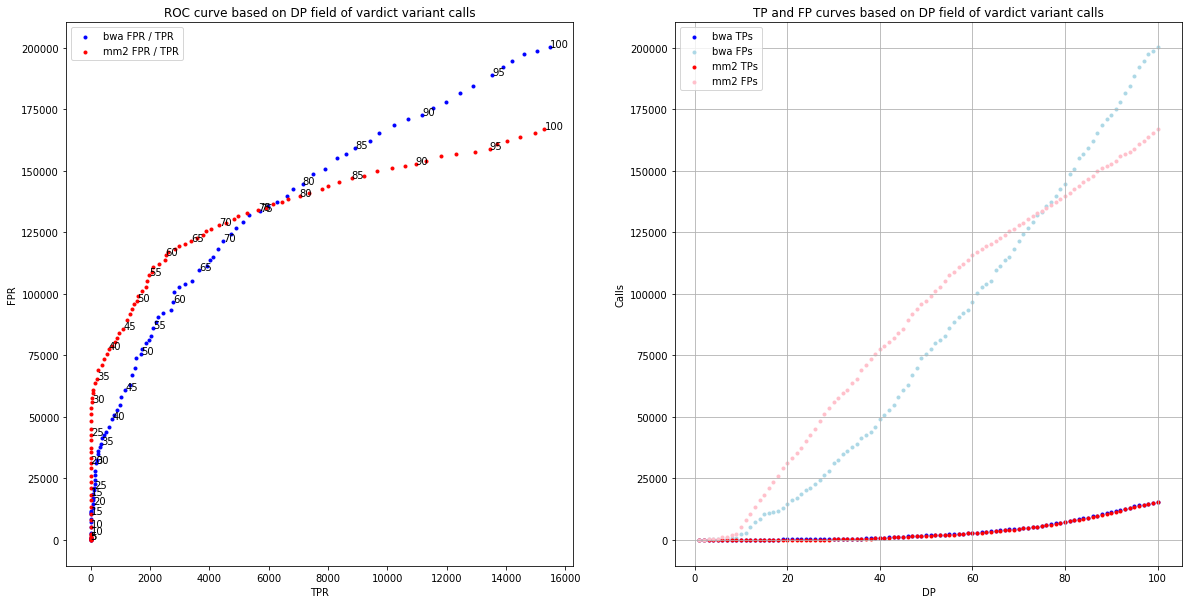

In [84]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'dp', 1, 100, 1)
pass

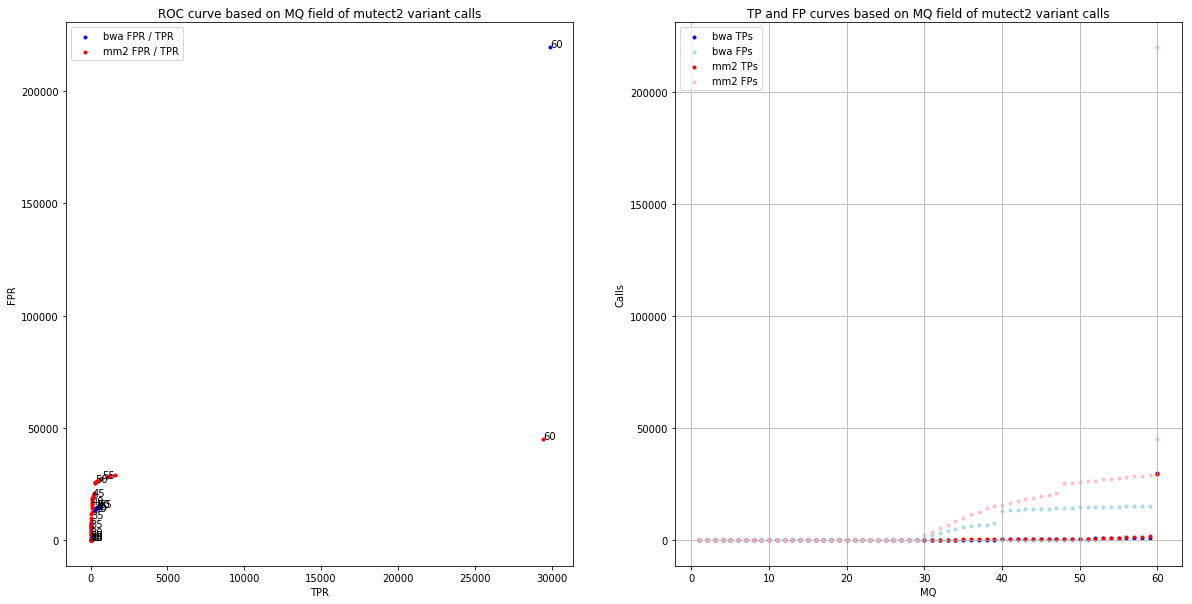

In [83]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'mq', 1, 60, 1)
pass

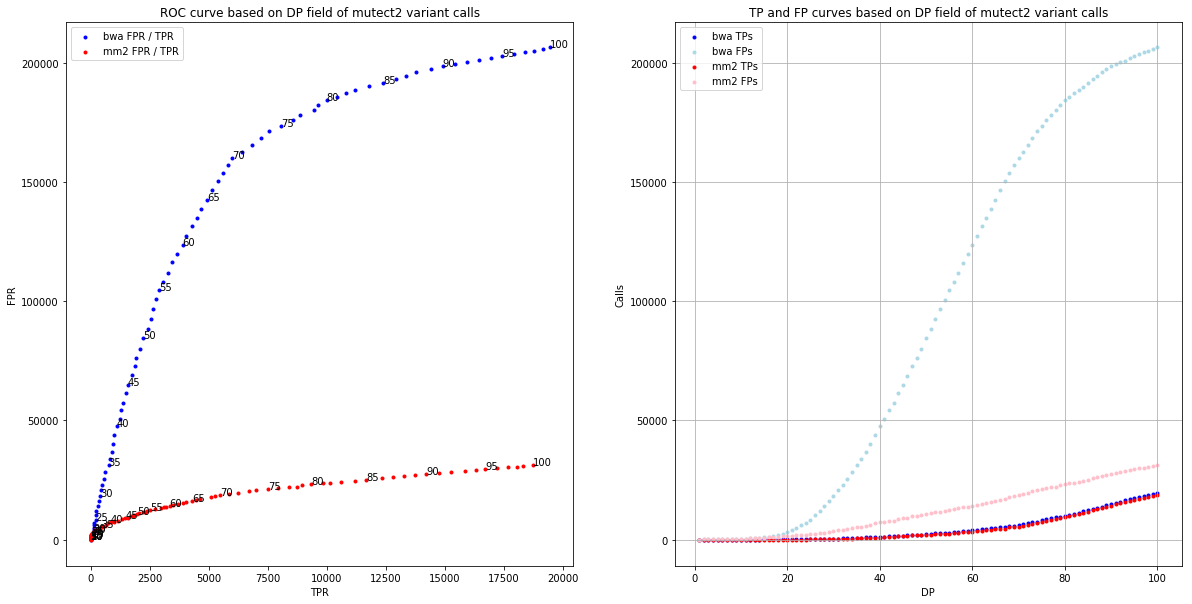

In [85]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'dp', 1, 100, 1)
pass

Plotting variants with X axis as a genome position, and Y axis as a feature (MQ, DP, etc). 
- red dot represent a variant called with minimap2
- blue dot represent a variant called wit BWA
- variants called with both aligners are connected with vertical lines
- pale colors represent false positives, bright colors correspond to true positives
- green dots at the bottom represent shared false negatives (i.e. true variants not called with any aligner)
- those that overlap with low complexity or high/low tricky regions, scatterred with x; others scatterred with .

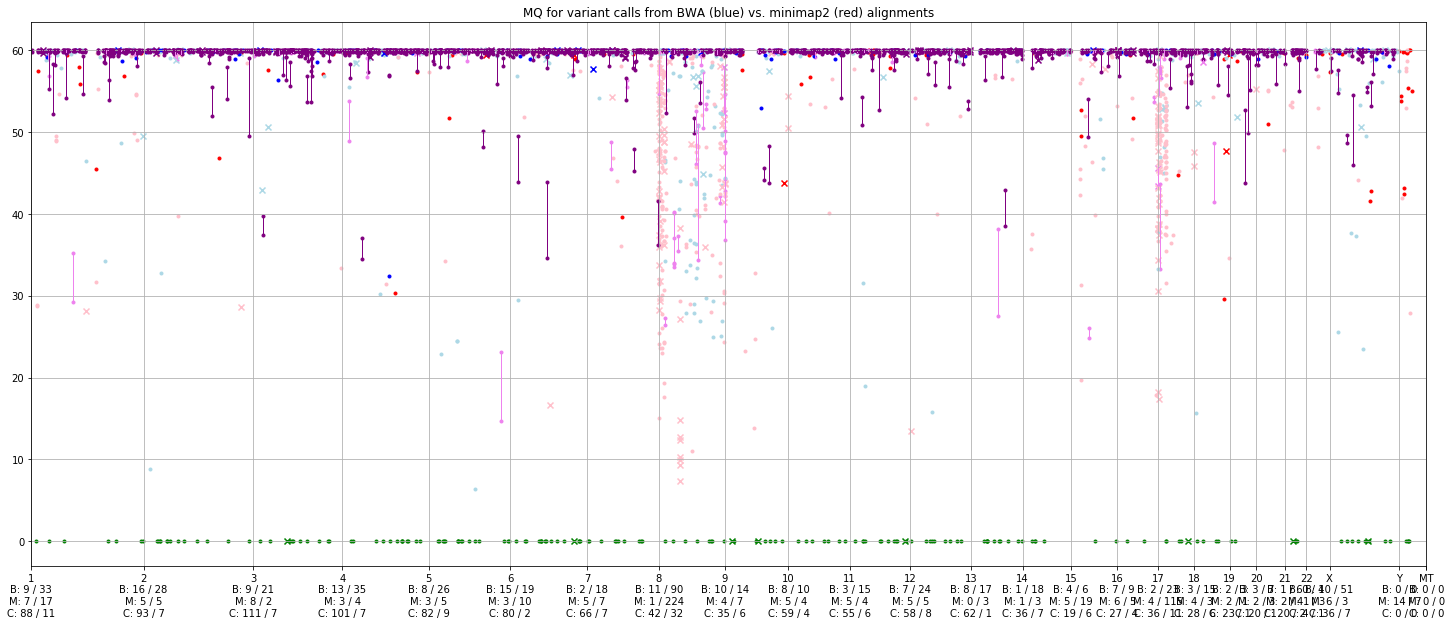

In [47]:
df, ax = plot('strelka2', 'mq')

# Annotate dots with gene names:
# for _, r in df[df[f'bwa_mq'] < 20][df[f'bwa_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'bwa_mq']))
# for _, r in df[df[f'mm2_mq'] < 20][df[f'mm2_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'mm2_mq']))

# Observations:
# - Chromosome 8: many bwa and minimap FP, but only few are shared.
# 
# TODO: 
# - ROC and other validatiopn stats based on MQ
# - Figure out high depth regions

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]
8
9
[('8', 1392795690), ('9', 1539159712)]


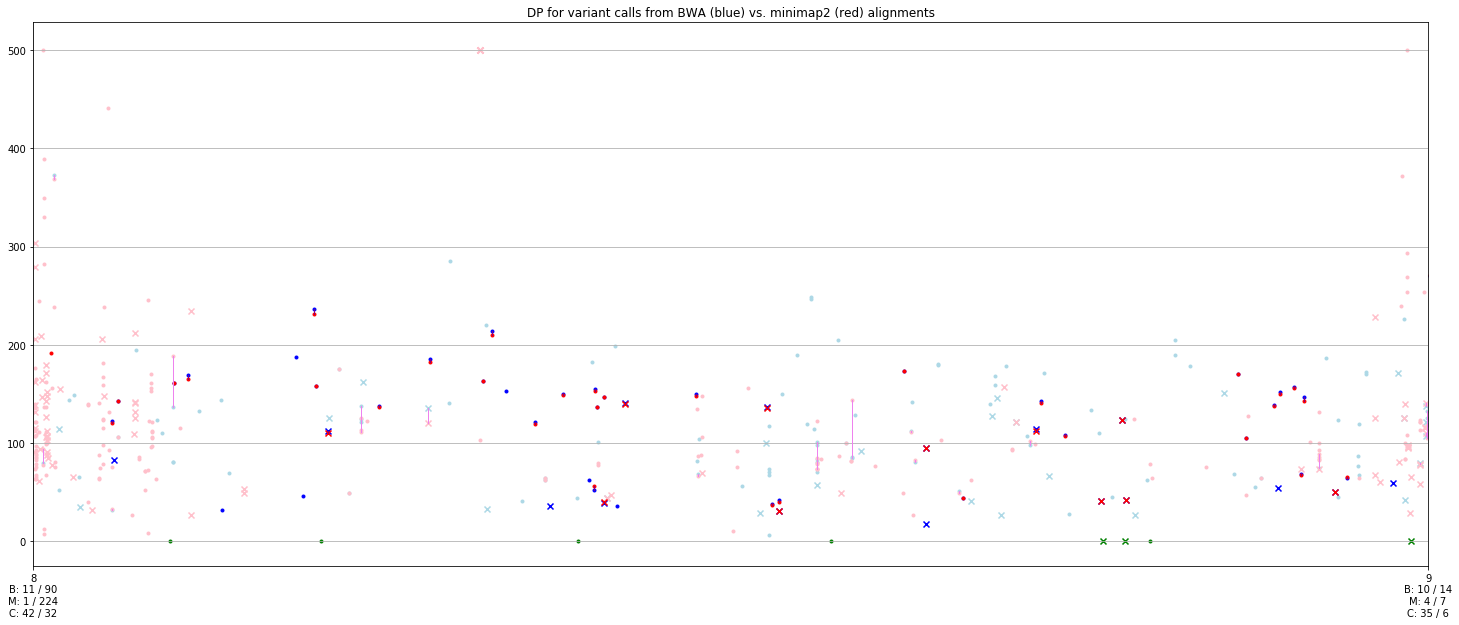

In [32]:
df, ax = plot('strelka2', 'dp', chrom=8, max_y=500)

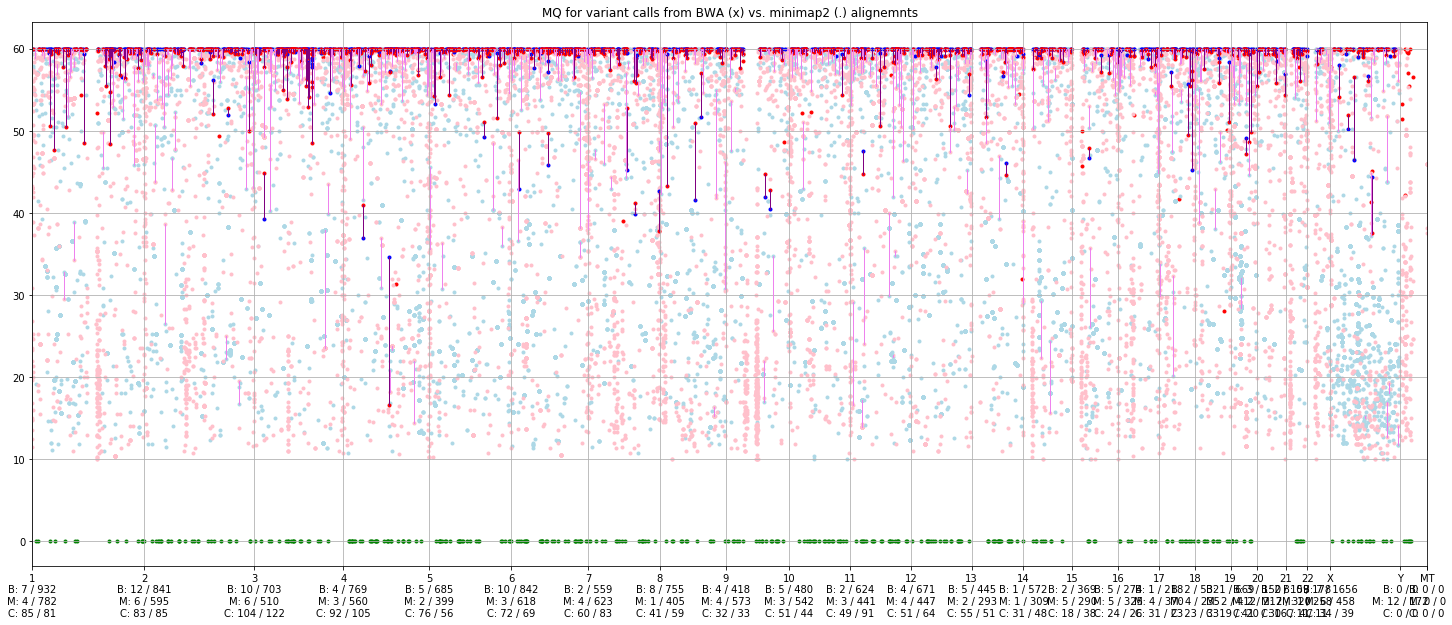

In [255]:
plot('vardict', 'mq')
pass

[('1', 0), ('2', 249250621), ('3', 492449994), ('4', 690472424), ('5', 881626700), ('6', 1062541960), ('7', 1233657027), ('8', 1392795690), ('9', 1539159712), ('10', 1680373143), ('11', 1815907890), ('12', 1950914406), ('13', 2084766301), ('14', 2199936179), ('15', 2307285719), ('16', 2409817111), ('17', 2500171864), ('18', 2581367074), ('19', 2659444322), ('20', 2718573305), ('21', 2781598825), ('22', 2829728720), ('X', 2881033286), ('Y', 3036303846), ('MT', 3095677412), (None, 3095693981)]


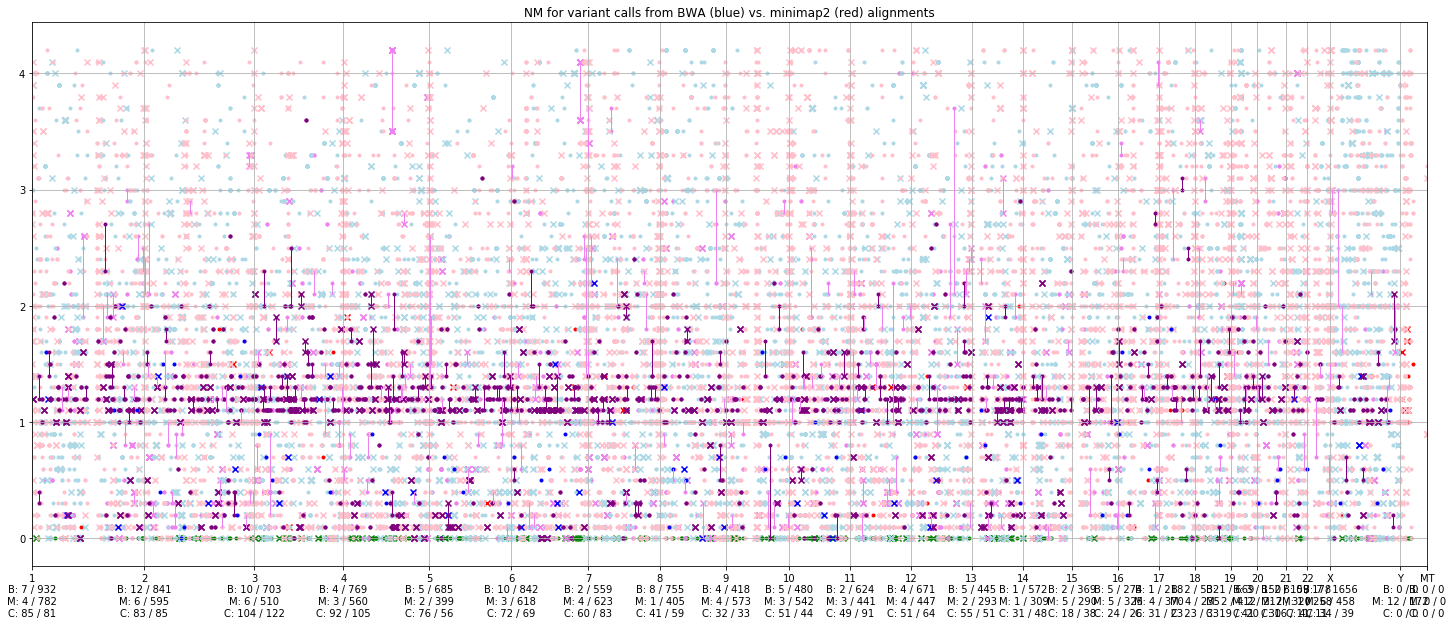

In [38]:
plot('vardict', 'nm')
pass

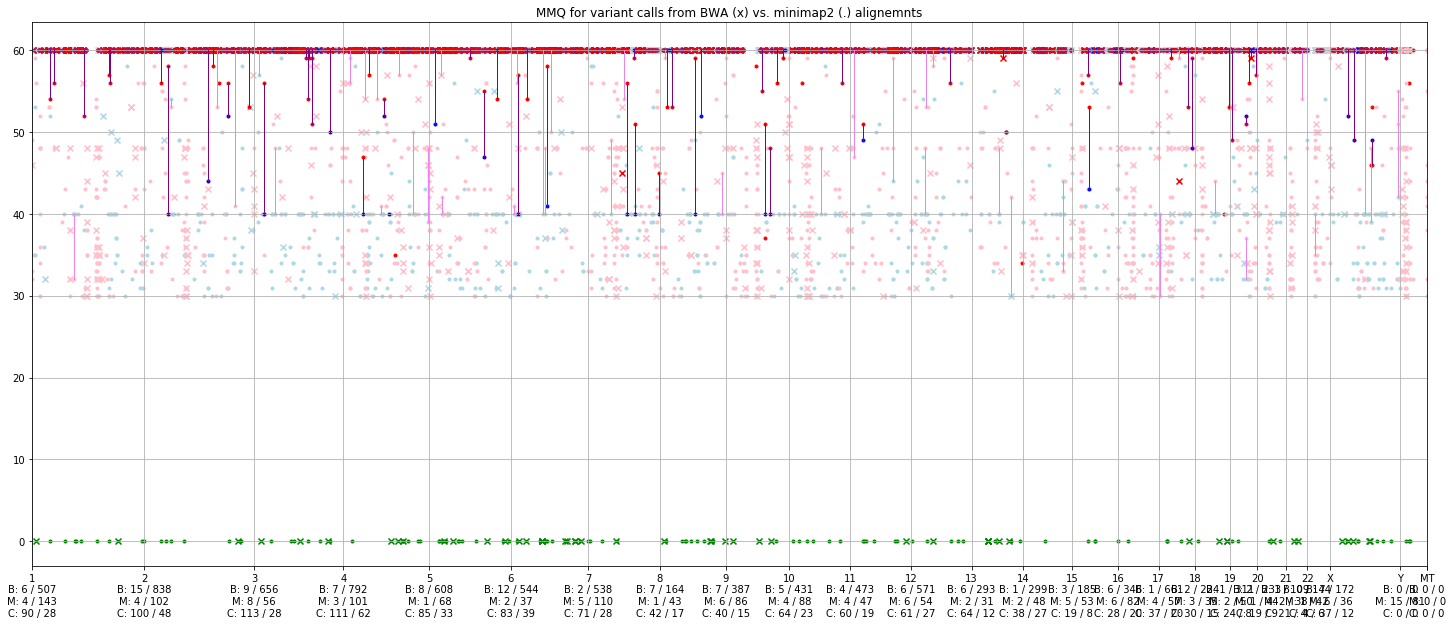

In [13]:
plot('mutect2', 'mq', 'MMQ')
pass

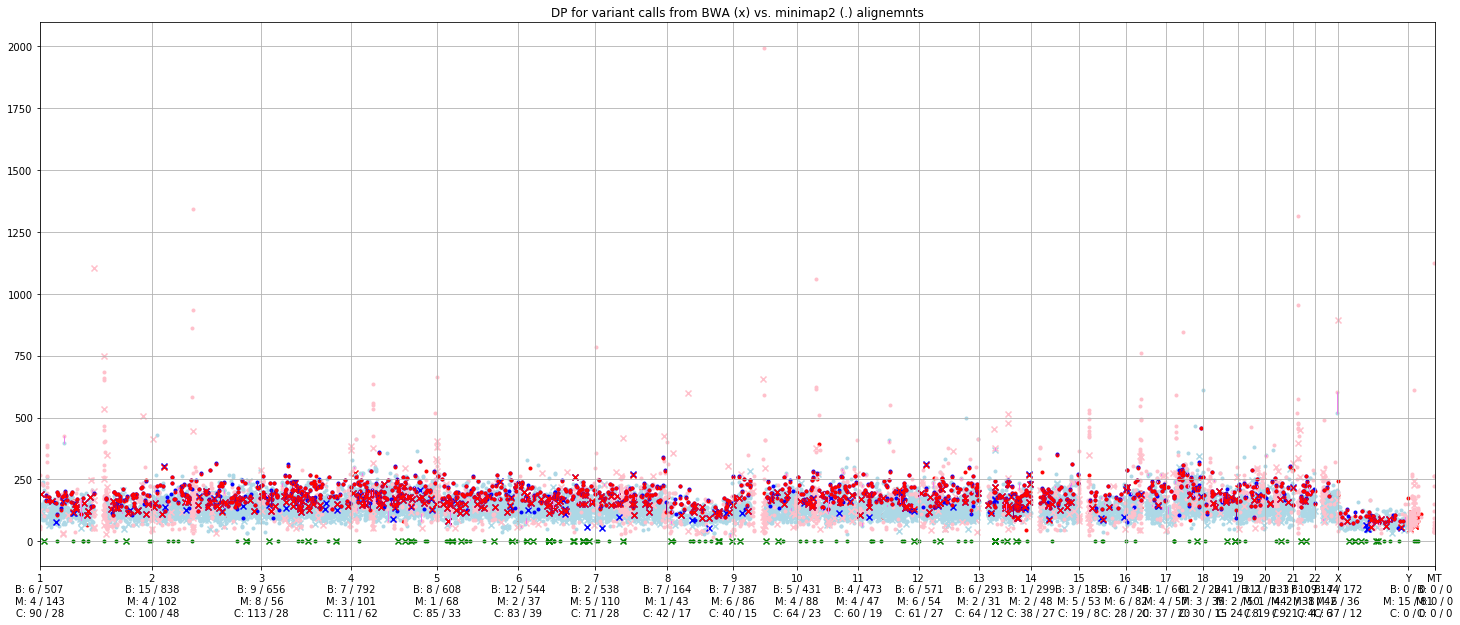

In [12]:
plot('mutect2', 'dp')
pass